In [11]:
# Snippet 1: Load, filter, train, reduce, label & compute embeddings once
# -----------------------------------------------------------------------
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import os
load_dotenv()

hf_token = os.getenv("HF_TOKEN")

# 1. Load and filter
data = pd.read_csv('/content/clean_data.csv')
data = data[data['comment_clean'].str.split().str.len() >= 5]
docs     = data['comment_clean'].fillna("").tolist()
raw_docs = data['comment_body'].fillna("").tolist()

# 2. Embedding model
TOKEN = hf_token
embedding_model = SentenceTransformer(
    "all-distilroberta-v1",
    use_auth_token=TOKEN
)

# 3. Train BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    calculate_probabilities=False,
    verbose=True,
    min_topic_size=30
)
topics, _ = topic_model.fit_transform(docs)

# 4. Reduce to top-3 topics
top_n = 3
topic_model.reduce_topics(docs, nr_topics=top_n)
topics, _ = topic_model.transform(docs)

# 5. Generate human-readable labels
def make_label(tid, k=3):
    return " / ".join([w for w,_ in topic_model.get_topic(tid)[:k]])

topic_info = topic_model.get_topic_info()
top_topics = (
    topic_info[topic_info.Topic >= 0]
              .nlargest(top_n, 'Count')
)
label_map = {row.Topic: make_label(row.Topic)
             for _, row in top_topics.iterrows()}
topic_model.set_topic_labels(label_map)

# 6. Compute document embeddings
embeddings = embedding_model.encode(docs, show_progress_bar=True)


c:\Users\belen\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
# Snippet 2: UMAP projection
# ------------------------------------------------
from umap import UMAP

umap_reducer = UMAP(
    n_neighbors=15,
    n_components=2,
    metric='cosine',
    random_state=42
)
coords_umap = umap_reducer.fit_transform(embeddings)


In [ ]:
# Snippet 3: Compute coherence & build summary
# -----------------------------------------------------------------------
import numpy as np
from sentence_transformers import util
import pandas as pd

def compute_topic_coherence(topic_model, embed_model, top_k=10):
    coherence = {}
    for tid in topic_model.get_topics().keys():
        if tid == -1: continue
        words = [w for w,_ in topic_model.get_topic(tid)[:top_k]]
        emb   = embed_model.encode(words, convert_to_tensor=True)
        cos   = util.pytorch_cos_sim(emb, emb)
        vals  = cos[np.tril_indices(cos.shape[0], -1)]
        coherence[tid] = round(vals.mean().item() if vals.numel() else 0.0, 3)
    return coherence

topic_coherence = compute_topic_coherence(topic_model, embedding_model)

summary = []
for tid, label in label_map.items():
    idxs    = [i for i,t in enumerate(topics) if t==tid][:1]
    example = raw_docs[idxs[0]] if idxs else "(no example)"
    summary.append({
        "Topic":     label,
        "Coherence": topic_coherence.get(tid, 0.0),
        "Example":   example
    })

df_summary = pd.DataFrame(summary).sort_values("Coherence", ascending=False)
print(df_summary.to_string(index=False))


                        Topic  Coherence                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

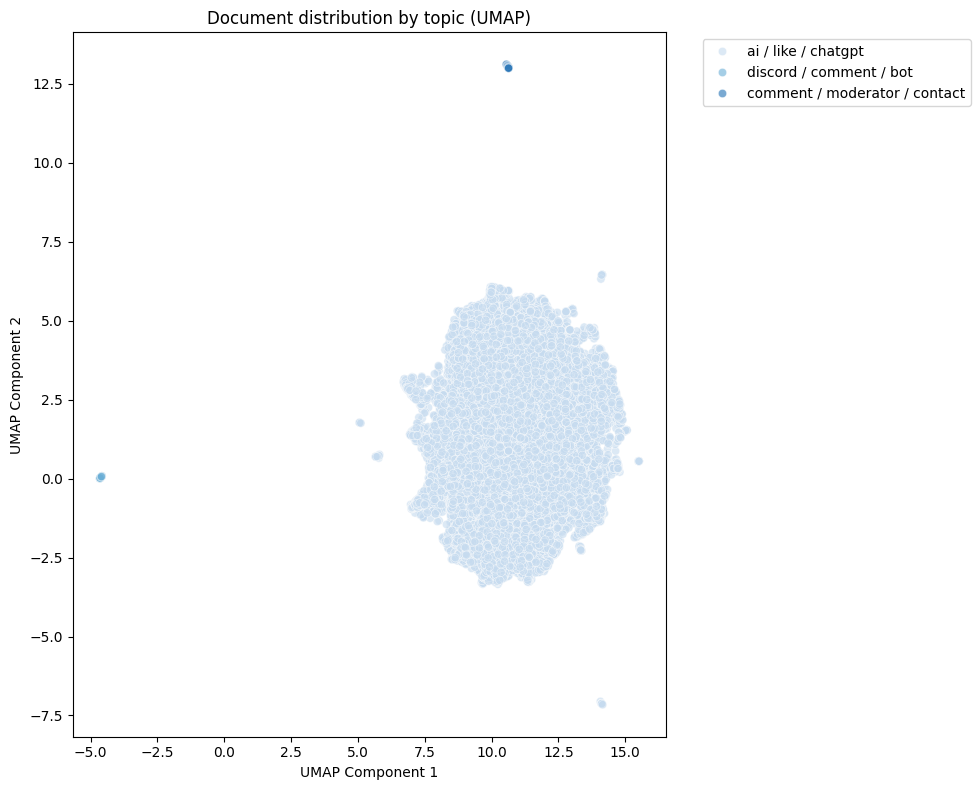

In [ ]:
# Snippet 4: Visualize with UMAP
# ----------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

doc_info = topic_model.get_document_info(docs)
df_umap = pd.DataFrame({
    "UMAP1": coords_umap[:, 0],
    "UMAP2": coords_umap[:, 1],
    "Topic": doc_info["Topic"].map(label_map)
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_umap,
    x="UMAP1", y="UMAP2",
    hue="Topic",
    palette="Blues",
    alpha=0.6
)
plt.title("Document distribution by topic (UMAP)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


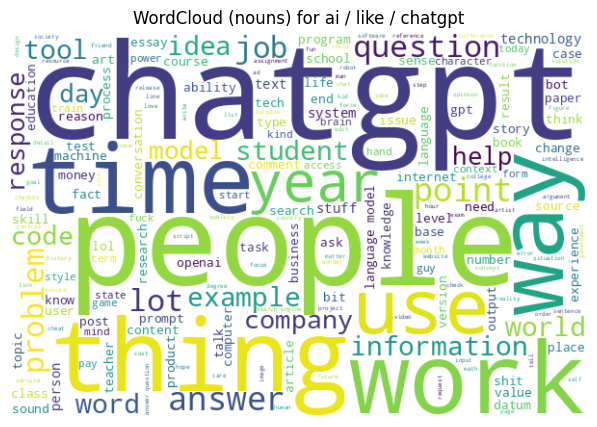

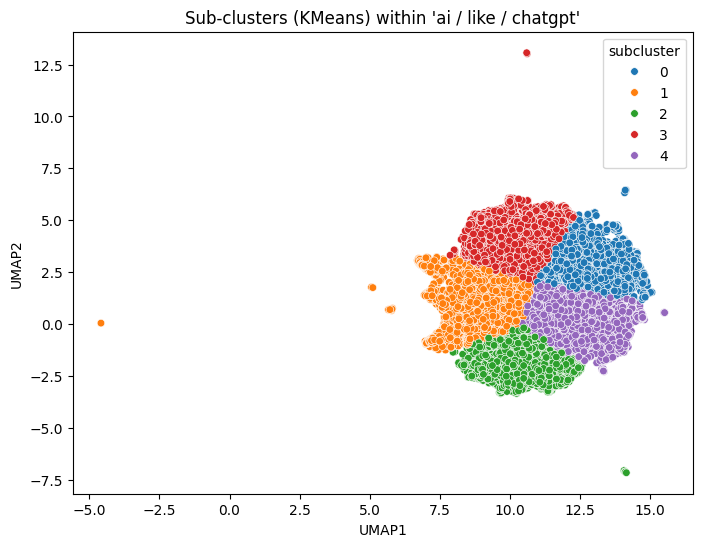

Saved CSV ➞ /content/clustered_with_subclusters.csv (cols: comment_clean, original_cluster, subcluster)


In [ ]:
# -------------------------------------------------------
# Snippet: WordCloud + KMeans sub‐clustering + CSV
# -------------------------------------------------------
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import numpy as np
import pandas as pd
import gc
from sklearn.cluster import KMeans


# 1. WordCloud (nouns only)
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
target_label = "ai / like / chatgpt"
topic_id     = next(tid for tid,lbl in label_map.items() if lbl==target_label)

mask   = np.array(topics) == topic_id
docs_i = [d for d,m in zip(docs,mask) if m]

nouns = []
for doc in nlp.pipe(docs_i, batch_size=64):
    nouns.extend([tok.lemma_ for tok in doc if tok.pos_=="NOUN"])

wc = WordCloud(width=600, height=400, background_color="white")\
     .generate(" ".join(nouns))
plt.figure(figsize=(8,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud (nouns) for {target_label}")
plt.show()
del nouns, wc
gc.collect()

# 2. Sub‐clustering with KMeans on UMAP coords
coords_sub = coords_umap[mask]   
n_sub      = 5                   

km = KMeans(n_clusters=n_sub, random_state=42)
sub_labels = km.fit_predict(coords_sub)


# 3. Visualize sub‐clusters on UMAP
import seaborn as sns
df = pd.DataFrame({
    "UMAP1": coords_sub[:,0],
    "UMAP2": coords_sub[:,1],
    "subcluster": sub_labels
})
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="subcluster", palette="tab10", s=30)
plt.title(f"Sub-clusters (KMeans) within '{target_label}'")
plt.show()

# 4. Annotate full DataFrame & export CSV
data = pd.read_csv('/content/clean_data.csv')
data = data[data['comment_clean'].str.split().str.len()>=5].reset_index(drop=True)
data['original_cluster'] = topics
data['subcluster']       = -1

orig_idxs = np.where(mask)[0]
for rel_pos, sub in zip(orig_idxs, sub_labels):
    data.at[rel_pos, 'subcluster'] = int(sub)

out = "/content/clustered_with_subclusters.csv"
data.to_csv(out, index=False)
print(f"Saved CSV ➞ {out} (cols: comment_clean, original_cluster, subcluster)")


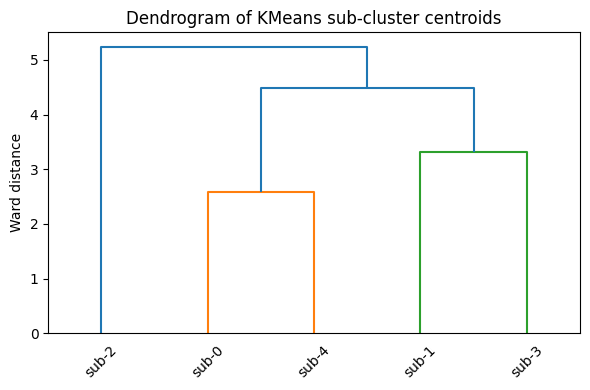

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# 1) Centroids
centroids = km.cluster_centers_  

# 2) Linkage Matrix 
Zc = linkage(centroids, method="ward")

# 3) Dendrogam of just 5 leaves
plt.figure(figsize=(6, 4))
dendrogram(
    Zc,
    labels=[f"sub-{i}" for i in range(centroids.shape[0])],
    leaf_rotation=45,
    leaf_font_size=10,
    color_threshold=None
)
plt.title("Dendrogram of KMeans sub‐cluster centroids")
plt.ylabel("Ward distance")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd 

df_check = pd.read_csv('data/clustered_with_subclusters.csv')


In [5]:
df_check.head()

,Unnamed: 0.1,Unnamed: 0,comment_body,subreddit,comment_clean,original_cluster,subcluster
0,1,1,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,angry right waste time read post sub clickbait...,0,3
1,2,2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,chatgpt karma whore folk think stream think bu...,0,0
2,5,5,"Wow, way to discover the most basic functional...",r/ChatGPT,wow way discover basic functionality language ...,0,4
3,6,6,"People on Reddit seek the karma and the fame,\...",r/ChatGPT,people reddit seek karma fame chatcpt assistan...,0,3
4,8,8,What's the point of even trying to click-bait ...,r/ChatGPT,point try click bait reddit youtube view impor...,0,3


In [10]:
# -----------------------------------------------
# Snippet: Sample 2 examples per original and sub‐cluster
# -----------------------------------------------

# 1) Take 2 random examples from each original_cluster
examples_orig = (
    df_check
    .groupby("original_cluster")
    .apply(lambda df: df.sample(n=2, random_state=42))
    .reset_index(drop=True)
)
examples_orig["sample_type"] = "orig_cluster"

# 2) Take 2 random examples from each subcluster (excluding -1 if present)
mask_valid = df_check["subcluster"] >= 0
examples_sub = (
    df_check[mask_valid]
    .groupby("subcluster")
    .apply(lambda df: df.sample(n=2, random_state=42))
    .reset_index(drop=True)
)
examples_sub["sample_type"] = "subcluster"

# 3) Combine into a single DataFrame
df_samples = pd.concat([examples_orig, examples_sub], ignore_index=True)

# 4) Display
df_samples.to_csv('data/examples_to_overleaf.csv')


C:\Users\belen\AppData\Local\Temp\ipykernel_19296\1152371220.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(n=2, random_state=42))
C:\Users\belen\AppData\Local\Temp\ipykernel_19296\1152371220.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(n=2, random_state=42))
